In [1]:
from IdentificationDataset import CleanID, FeatureFusionID, DereverberID, SingleNodeID
from IdentificationDataset2 import NoisyID
import torch
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np

c
c
c
torch.Size([280]) tensor([0., 0., 0., 0., 0., 1.])


In [2]:
p = "/home/student/Documents/WHK_Projekt_1/code_DR/Dereverber_saves/DR-S1L_candidate"
v = 'siamese'
allsets_old = [ConcatDataset([CleanID(train=True), CleanID(validation=True), CleanID(test=True)]),
               ConcatDataset([FeatureFusionID(train=True), FeatureFusionID(validation=True), FeatureFusionID(test=True)]),
               ConcatDataset([DereverberID(p,v,train=True), DereverberID(p,v,validation=True), DereverberID(p,v,test=True)]),
               ConcatDataset([SingleNodeID(train=True), SingleNodeID(validation=True), SingleNodeID(test=True)])]
allsets_new = [NoisyID(clean=True),
                NoisyID(dereverberationMethod=None, noiseReductionMethod=None),
                NoisyID(dereverberationMethod='baseline', noiseReductionMethod='baseline'),
                NoisyID(dereverberationMethod='neural net', noiseReductionMethod='baseline'),
                NoisyID(dereverberationMethod='baseline', noiseReductionMethod='neural net'),
                NoisyID(dereverberationMethod='nerual net', noiseReductionMethod='neural net')]

In [3]:
def analyze_dataset(dataset):
    loader = DataLoader(dataset)
    n = len(dataset)
    inpmax = np.zeros(n, dtype=np.float16)
    inpmin = np.zeros(n, dtype=np.float16)
    class_tally = np.zeros(6, dtype=np.uint8)
    for i, (inp, trg, *_) in enumerate(loader):
        if trg.size(-1) == 1:
            class_tally[trg[-1]] += 1
        elif trg.size(-1) == 6:
            class_tally[torch.argmax(trg)] += 1
        else:
            raise ValueError('1')
        inpmax[i] = torch.max(inp)
        inpmin[i] = torch.min(inp)
    print(f'Class Tally: {class_tally}')
    print(f'Max: mean={np.mean(inpmax):.3f}, std={np.std(inpmax):.3f}')
    print(f'Min: mean={np.mean(inpmin):.3f}, std={np.std(inpmin):.3f}')
    print('')

print("\033[0;31mOLD SETS\033[0m")
names = ['clean', 'ff', 'derev', 'noisy']
for dataset, name in zip(allsets_old,names):
    print(name)
    analyze_dataset(dataset)
print("\033[0;34mNEW SETS\033[0m")
names = ['clean', 'bl bl', 'nn bl', 'bl nn', 'nn nn']
for dataset, name in zip(allsets_new,names):
    print(name)
    analyze_dataset(dataset)


OLD SETS
clean
Class Tally: [ 84  56  72  92  60 112]
Max: mean=3.170, std=2.312
Min: mean=0.000, std=0.000

ff
Class Tally: [ 84  56  72  92  60 112]
Max: mean=8.469, std=3.521
Min: mean=0.000, std=0.000

derev
Class Tally: [ 84  56  72  92  60 112]
Max: mean=0.994, std=0.022
Min: mean=0.000, std=0.000

noisy
Class Tally: [ 84  56  72  92  60 112]
Max: mean=8.359, std=3.732
Min: mean=0.000, std=0.000

NEW SETS
clean
Class Tally: [ 84  56  71  91  60 110]
Max: mean=4.156, std=4.227
Min: mean=0.000, std=0.000

bl bl
Class Tally: [ 84  56  71  91  60 110]
Max: mean=0.142, std=0.106
Min: mean=0.000, std=0.000

nn bl
Class Tally: [ 84  56  71  91  60 110]
Max: mean=0.133, std=0.100
Min: mean=-0.005, std=0.005

bl nn
Class Tally: [ 84  56  71  91  60 110]
Max: mean=0.028, std=0.002
Min: mean=-0.001, std=0.001

nn nn
Class Tally: [ 84  56  71  91  60 110]
Max: mean=0.164, std=0.088
Min: mean=-0.032, std=0.006



In [4]:
import re
clean_old = allsets_old[0]
clean_new = allsets_new[0]

def f(s):
    return re.sub(r'_as_.', '', s)
print(len(clean_old), len(clean_new))
paths_old = []
paths_new = []
for i in range(476):
    _, _, p_old = clean_old[i]
    p_old = p_old.split('ker_')[1].split('.npy')[0]
    paths_old.append(p_old)
    if i < 472:
        _, _, p_new = clean_new[i]
        p_new = f(p_new.split('reset/')[1])
        paths_new.append(p_new)
print(len(paths_old), len(paths_new))

476 472
476 472


In [5]:
paths_old_sort = list(np.sort(paths_old))
paths_new_sort = list(np.sort(paths_new))
print('Missing samples in new set:')
print(paths_old_sort.pop(151))
print(paths_old_sort.pop(226))
print(paths_old_sort.pop(369))
print(paths_old_sort.pop(443))
for i in range(472):
    if not paths_old_sort[i] == paths_new_sort[i]:
        print(i)

Missing samples in new set:
4077/exp_128/seq_3
6341/exp_128/seq_3
8230/exp_117/seq_3
8230/exp_4/seq_2


In [6]:
paths_old_indices = list(np.argsort(paths_old))
paths_new_indices = list(np.argsort(paths_new))
paths_old_indices[151] = -1
paths_old_indices[226+1] = -2
paths_old_indices[369+2] = -3
paths_old_indices[443+3] = -4

In [7]:
all_inp_sort = np.zeros((2, 472, 280))
all_trg_sort = np.zeros((2, 472))
for i in range(472):
    inp_o, trg_o, _ = clean_old[paths_old_indices[i]]
    all_inp_sort[0,i,:] = inp_o
    all_trg_sort[0,i] = np.argmax(trg_o)
    
    inp_n, trg_n, _ = clean_new[paths_new_indices[i]]
    all_inp_sort[1,i,:] = inp_n
    all_trg_sort[1,i] = np.argmax(trg_n)

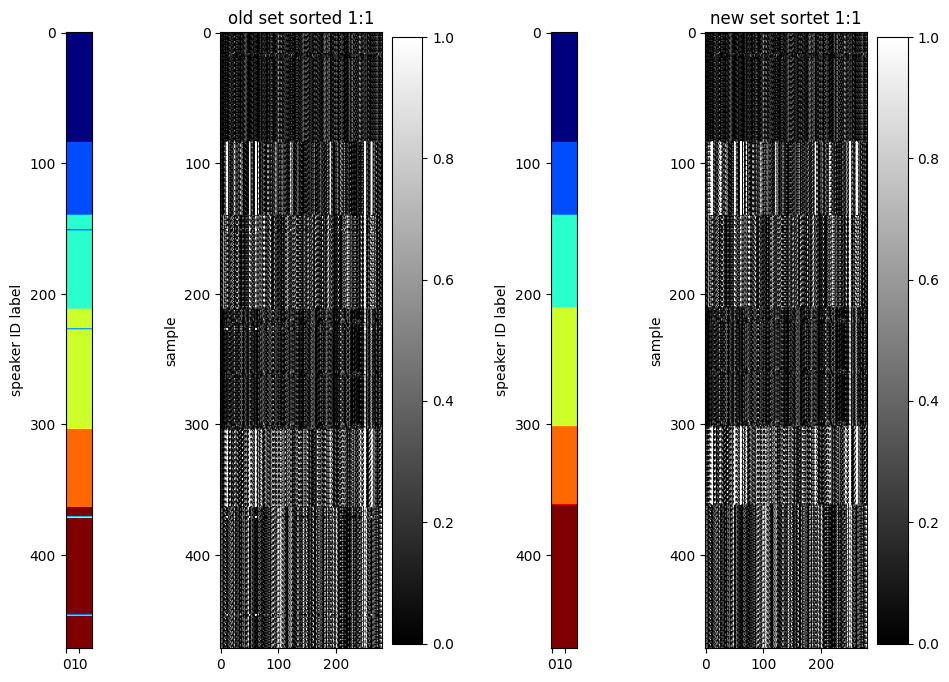

1705/exp_109/seq_0
max old: 8.403, max new: 16.499


In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.subplot(1,4,1)
plt.imshow(np.repeat(all_trg_sort[[0]], 20, axis=0).T, cmap='jet')
plt.ylabel('speaker ID label')
plt.subplot(1,4,2)
plt.imshow(all_inp_sort[0], aspect='auto', cmap='gray', vmax=1)
plt.colorbar()
plt.title('old set sorted 1:1')
plt.ylabel('sample')
plt.subplot(1,4,3)
plt.imshow(np.repeat(all_trg_sort[[1]], 20, axis=0).T, cmap='jet')
plt.ylabel('speaker ID label')
plt.subplot(1,4,4)
plt.imshow(all_inp_sort[1], aspect='auto', cmap='gray', vmax=1)
plt.colorbar()
plt.title('new set sortet 1:1')
plt.ylabel('sample')
plt.show()
print(paths_new_sort[0])
print(f'max old: {all_inp_sort[0].max():.3f}, max new: {all_inp_sort[1].max():.3f}')

In [9]:
import pickle
file = open('speakers_train.pkl', 'rb')
data = pickle.load(file)
file.close()

train_speakers = []
for i in range(len(data)):
    #print(data[i]['id'])
    train_speakers.append(int(data[i]['id']))

print(np.sort(train_speakers))

path = '/home/student/Documents/WHK_Projekt_1/work_remastered/DATA aus der Bachelorarbeit (Denkmalgeschützt)/LMBE_DATA_unvollständig/LMBEs_traindata/163/'

a = np.load(path+'163-121908-0001.npy')
a.min()
path = '/home/student/Documents/WHK_Projekt_1/work_remastered/DATA/CLEAN_LMBE_DATA/exp_0/speaker_345/'
b = np.load(path+'seq_0.npy')
b.min()

[  26   39   83   87  118  125  150  163  200  201  211  226  229  233
  248  250  254  289  298  302  307  322  374  403  426  445  446  481
  669  696  831  839  909  911 1040 1069 1081 1088 1116 1183 1235 1246
 1355 1447 1624 1723 1737 1743 1841 1867 1926 1992 2007 2092 2136 2159
 2196 2289 2518 2817 2836 2893 2910 2911 2952 2989 3112 3214 3235 3240
 3242 3259 3374 3436 3440 3526 3664 3699 3723 3807 3830 3879 3947 3982
 3983 4014 4051 4088 4160 4195 4214 4297 4397 4441 4481 4640 4680 4853
 4898 5022 5049 5104 5163 5322 5339 5390 5393 5463 5514 5652 5688 5703
 5778 5789 5808 6019 6064 6209 6272 6367 6385 6476 6529 6818 6836 6848
 7067 7078 7113 7190 7226 7264 7302 7402 7447 7505 7511 7517 7780 7800
 7859 8014 8088 8098 8108 8238 8312 8419 8425 8580 8609 8629 8630 8747
 8770 8838 8975]


0.0

8.194182e-06 0.0


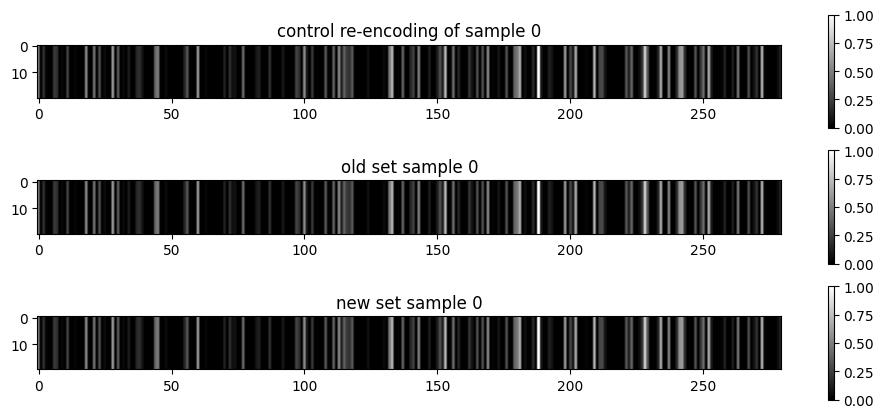

In [10]:
bn_0 = np.load('bn_util_debug.npy')
bn_0.shape

bn_0_old = clean_old[paths_old_indices[0]][0].numpy()
bn_0_new = clean_new[paths_new_indices[0]][0].numpy()

diff_old = bn_0_old-bn_0
diff_new = bn_0_new-bn_0

print((diff_old**2).sum(), (diff_new**2).sum())


plt.figure(figsize=(12,5))
plt.subplot(3,1,1)
plt.imshow(np.repeat(np.expand_dims(bn_0, 1) ,20,1).T, cmap='gray', vmax=1)
plt.colorbar()
plt.title('control re-encoding of sample 0')
plt.subplot(3,1,2)
plt.imshow(np.repeat(np.expand_dims(bn_0_old, 1) ,20,1).T, cmap='gray', vmax=1)
plt.colorbar()
plt.title('old set sample 0')
plt.subplot(3,1,3)
plt.imshow(np.repeat(np.expand_dims(bn_0_new, 1) ,20,1).T, cmap='gray', vmax=1)
plt.colorbar()
plt.title('new set sample 0')
plt.show()
